# Purpose

This notebook is to test whether the `neuro_op` module's agents can successfully infer `world_dist` if only that distribution's information pieces are absorbed (i.e., with rates h>0, r=0).

For this, the model is run and agents informed with different numbers of information exchanged (i.e., different `t_max`, `h`). Then, each agent will produce its posterior predictive distribution by sampling

In [2]:
import neuro_op as nop
import matplotlib.pyplot as plt
#import networkx as nx
import numpy as np
import scipy.stats as st

In [3]:
N_beliefs = 500

agents, G, beliefs, world, N_events, t_end = nop.run_model(
    N_agents=100,
    N_neighbours=3,
    N_beliefs=500,
    belief_min=-50,
    belief_max=50,
    log_priors=np.zeros(N_beliefs),
    likelihood=st.norm(loc=0, scale=5),
    world_dist=st.norm(loc=0, scale=5),
    h=1,
    r=0,
    t_max=10000,
)

print(f"Number of events: {N_events}")

Number of events: 10168


In [4]:
plt.rcParams.update({"font.size": 25})

Text(0, 0.5, '$p(\\mu|x_i)$')

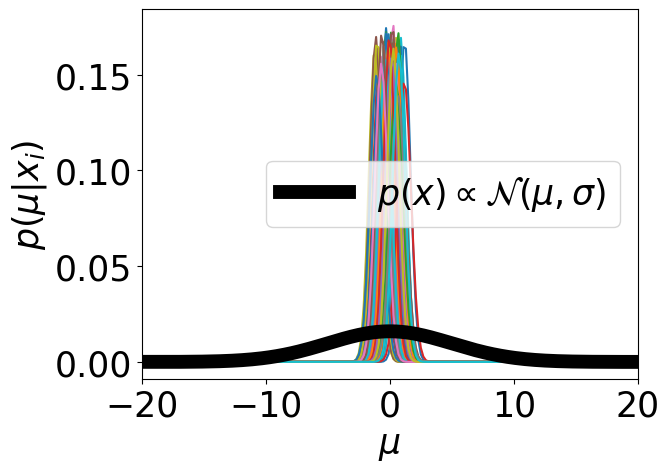

In [5]:
for i in range(len(agents)):
    plt.plot(agents[0].beliefs, nop.logpdf_to_pdf(agents[i].log_probs))
    plt.xlim([-20, 20])
plt.plot(
    beliefs,
    nop.logpdf_to_pdf(world.log_probs),
    color="black",
    linewidth=10,
    label="$p(x) \propto \mathcal{N}(\mu,\sigma)$",
)
plt.legend()
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu|x_i)$")

In [107]:
# Define parameters of data analysis
N_bins = 51  # go for uneven bin number to have a bin centered on 0
opinion_range = [-20, 20]  # chosen by experience, no formal reasoning

# Generate posterior predictive distributions (PPDs) for each agent by generating ppd samples and binning them into histograms
ppd_samples = [
    nop.ppd_Gaussian_mu(agent.beliefs, agent.log_probs, 10000) for agent in agents
]

ppds = [
    np.histogram(
        i,
        bins=N_bins,
        range=opinion_range,
    )
    for i in ppd_samples
]

# Extract the bin centers, i.e., the maximum likelihood estimates (MLEs) of each agent according to PPD samples
argmax = [np.argmax(hist_data[0]) for hist_data in ppds]
mu_agents = [
    (hist_data[1][i] + hist_data[1][i + 1]) / 2 for hist_data, i in zip(ppds, argmax)
]

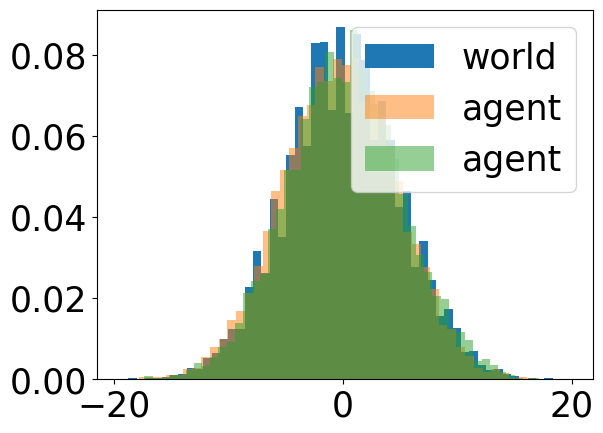

In [120]:
# Plot histograms for '''optical data analysis'''
plt.hist(world.diary_out, bins=N_bins, density=True, alpha=1, label="world")
for i in ppd_samples[:2]:
    plt.hist(i, bins=N_bins, density=True, alpha=.5, label="agent")
plt.legend()

In [13]:
# THIS CURRENTLY TAKES INFO SAMPLES FROM ALL AGENTS, NOT JUST ONE BY ONE!!!
Q_binned = nop.dist_binning(world.likelihood, range=[-20,20], N_bins=50)

P_sampled,_ = np.histogram(ppds, bins=50, range=[-20,20])
P_sampled = P_sampled / np.sum(P_sampled)

nop.kl_divergence(P_sampled, Q_binned)

0.0001239365564741066

In [8]:
help(nop.p_distances)

Help on function p_distances in module neuro_op.neuro_op:

p_distances(mu_agents, mu_ref, p=1, p_inv=1)
    Returns an average distance between an array of agents' inferred parameters and a reference parameter.
    
    Returns a distance between an array of agent-inferred generative model parameters and a reference value.
    Usually, the reference value of interest is the parameter encoding/generating the real world data
    (e.g., the mean of a Gaussian distribution).
    Usually, the array of MLEs is usually created from agents' posterior predictive distributions (PPDs).
    
    If p_inv = 1/p, this function returns the p-norm.
    If p_inv = 1, the return value is usually multiplied by 1/len(mu_agents) to obtain the mean distance.
    For sum of linear distances, choose p = 1, p_inv = 1  .
    For sum of quadratic distances, choose p = 2, p_inv = 1  .
    
    Keyword arguments:
    mu_agents -- array of values
    mu_ref -- reference value to which mu_agents values are compared
